In [1]:
%load_ext autoreload
%autoreload 2
from mmcontext.utils import setup_logging

logger = setup_logging()

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [12]:
from datasets import load_dataset

dataset_name = "cellxgene_pseudo_bulk_3_5k_multiplets_natural_language_annotation_cs50"
dataset = load_dataset(f"jo-mengr/{dataset_name}")

In [3]:
from sentence_transformers import SentenceTransformer

from mmcontext.models.mmcontextencoder import MMContextEncoder

enc = MMContextEncoder(
    "NeuML/pubmedbert-base-embeddings",
    adapter_hidden_dim=None,
    adapter_output_dim=None,
    output_token_embeddings=False,
    freeze_text_encoder=True,
    train_lookup=False,
)

In [4]:
# st = SentenceTransformer(modules=[enc])
st = SentenceTransformer("jo-mengr/mmcontext-cg_100k-cell_type-pubmedbert-2048-geneformer-sample_cs")

2025-07-08 12:56:48,508 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-07-08 12:56:48,509 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: jo-mengr/mmcontext-cg_100k-cell_type-pubmedbert-2048-geneformer-sample_cs
2025-07-08 12:56:50,121 - mmcontext.models.mmcontextencoder - WARNING - Loaded encoder was registered for 'geneformer' data. Call register_initial_embeddings() with compatible data before using it.


In [5]:
token_df, _ = st[0].get_initial_embeddings(
    dataset,
    layer_key="X_geneformer",
    download_dir=f"../../data/from_nxtcloud/{dataset_name}",
    axis="obs",
)
st[0].register_initial_embeddings(token_df, data_origin="geneformer")

2025-07-08 12:57:01,784 - mmcontext.file_utils - INFO - Found 2 unique share links across ['train', 'val'] splits
Processing: 100%|██████████| 2/2 [00:00<00:00, 6759.56file/s]
2025-07-08 12:57:01,788 - mmcontext.file_utils - INFO - Reading /Users/mengerj/repos/mmcontext/data/from_nxtcloud/cellxgene_pseudo_bulk_3_5k_multiplets_natural_language_annotation_cs50/chunk_0.zarr
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element 

Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [6]:
# enc.register_initial_embeddings(token_df, data_origin="geneformer")
dataset_ready = st[0].prepare_ds(dataset, primary_cell_sentence_col="cell_sentence_1", prefix=False)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [7]:
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

adata, local_path = load_test_adata_from_hf_dataset(
    dataset["train"], save_dir=f"../../data/from_nxtcloud/{dataset_name}"
)
adata, train_sub = subset_dataset_by_chunk(adata, dataset["train"])

2025-07-08 12:57:05,789 - mmcontext.file_utils - INFO - Found 1 unique share links across ['test'] splits
2025-07-08 12:57:05,789 - mmcontext.file_utils - INFO - Picked share-link https://nxc-fredato.imbi.uni-freiburg.de/s/tp4jHqYyRmCHnSs (out of 1)
Processing: 100%|██████████| 1/1 [00:00<00:00, 13025.79file/s]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_scvi_fm' was written without encoding metadata.
  re

In [8]:
dataset_train = dataset_ready["train"]

In [9]:
if "sentence_1" in dataset_train.column_names:
    omics_embeddings = st.encode(dataset_train["sentence_1"])
if "anchor" in dataset_train.column_names:
    omics_embeddings = st.encode(dataset_train["anchor"])
if "sentence_2" in dataset_train.column_names:
    text_embeddings = st.encode(dataset_train["sentence_2"])
if "positive" in dataset_train.column_names:
    text_embeddings = st.encode(dataset_train["positive"])
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["text_emb"] = text_embeddings

Batches: 100%|██████████| 73/73 [00:05<00:00, 13.90it/s]


In [10]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict={"omics": "mmcontext_emb", "text": "text_emb"},
    subset_size=20,
    label_keys=["dataset_title", "cell_type"],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-07-08 12:57:30,022 - mmcontext.eval.utils - INFO - Created DataFrame with 40 rows (20 samples × 2 modalities)


2025-07-08 12:57:32,802 - mmcontext.pl.plotting - WARNING - Requested n_samples (50) is greater than total unique sample_ids (20). Using all sample_ids instead.
2025-07-08 12:57:32,805 - mmcontext.pl.plotting - INFO - Applying UMAP to subset of size=40 with metric=cosine...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


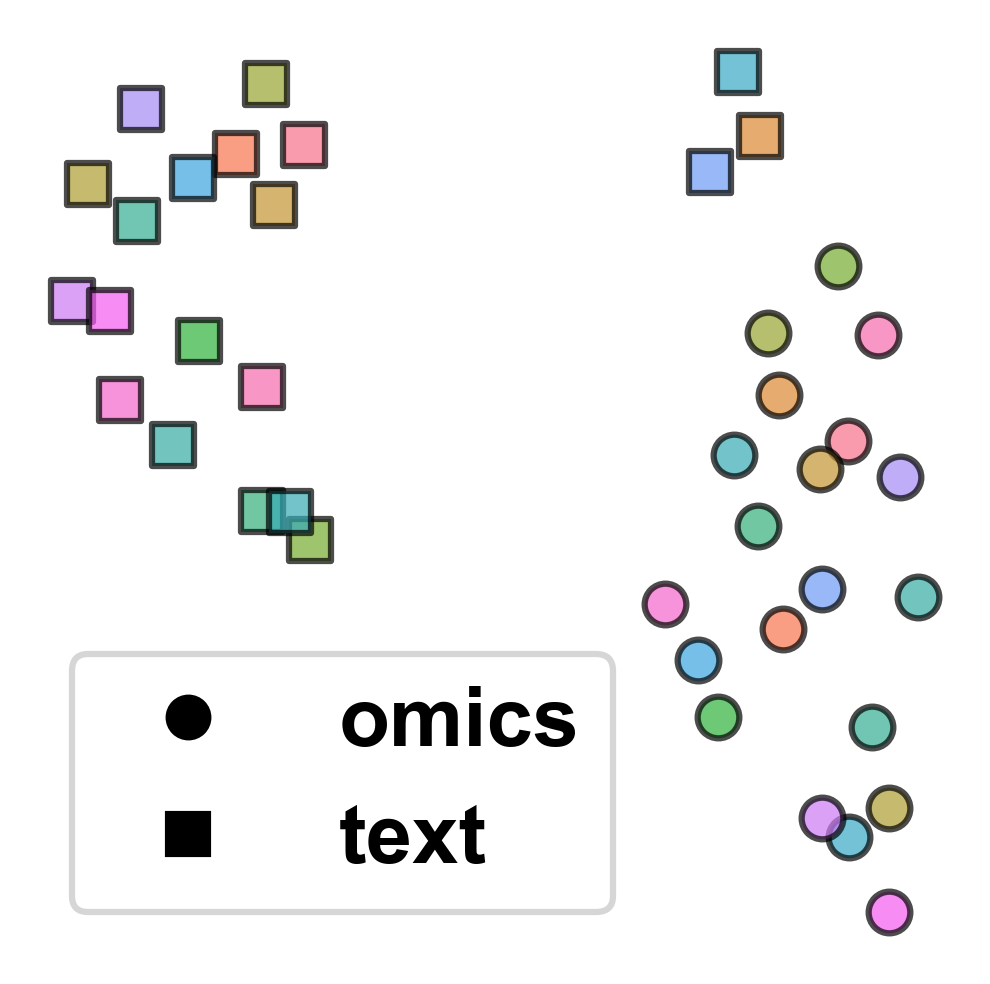

2025-07-08 12:57:35,057 - mmcontext.pl.plotting - INFO - Displayed embedding clusters interactively.


In [11]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(
    emb_pair_df,
    method="umap",
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    figsize=(4, 4),
    random_state=42,
    point_size=100,
    legend_fontsize=20,
)